In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import pmdarima as pm

## Load data and separate train from test-phase

There are cases where load and temp data are missing due to a blackout (see Known_Artifacts.md for an inexhaustive list)

We need to impute the temperature data to use it for training ARIMA-type models. We did NOT need this for the univariate model since complete data is only assumed for covariate (not the outcome).

In [2]:
base_data = pd.read_csv('data.csv', index_col=0)
base_data.index = pd.to_datetime(base_data.index)
base_data = base_data.asfreq('H')

imputed_data = base_data.copy()
for idx, row in imputed_data.iterrows():
    if np.isnan(row.tmp_f_KDFW):
        imputed_data.loc[idx].tmp_f_KDFW = base_data[
                                                    (base_data.index.month == idx.month) & 
                                                    (base_data.index.day == idx.day) & 
                                                    (base_data.index.hour == idx.hour)
                                                ].tmp_f_KDFW.mean()

In [3]:
train_data = imputed_data[imputed_data.index < '2021-07-01']
train_data = train_data.asfreq('H')
target_data = imputed_data[imputed_data.index >= '2021-07-01']
target_data = target_data.asfreq('H')

In [4]:
scaler = MinMaxScaler()
train_data[['tmp_f_KDFW', 'north_load']] = scaler.fit_transform(train_data[['tmp_f_KDFW', 'north_load']])

In [20]:
train_data.fillna(0, inplace=True)

In [23]:
model = pm.arima.AutoARIMA(start_p = 24,
                           d = None,
                           start_q = 6,
                           max_p = 48,
                           max_q = 12,
                           m=4,
                           seasonal=True,
                           trace=2)

model.fit(y=train_data.north_load, X=train_data.tmp_f_KDFW.values.reshape(-1,1))

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(1,0,1)[4] intercept   : AIC=-177375.316, Time=85.63 sec
First viable model found (-177375.316)
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=-147274.139, Time=7.79 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=-168937.815, Time=26.62 sec
 ARIMA(0,1,1)(0,0,1)[4] intercept   : AIC=-160932.262, Time=30.70 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=-147276.138, Time=9.17 sec
 ARIMA(3,1,3)(0,0,1)[4] intercept   : AIC=-177647.550, Time=89.92 sec
New best model found (-177647.550 < -177375.316)
 ARIMA(3,1,3)(0,0,0)[4] intercept   : AIC=-177359.403, Time=55.62 sec
 ARIMA(3,1,3)(0,0,2)[4] intercept   : AIC=-177521.351, Time=128.69 sec
 ARIMA(3,1,3)(1,0,0)[4] intercept   : AIC=-177366.734, Time=78.56 sec
 ARIMA(3,1,3)(1,0,2)[4] intercept   : AIC=-168585.736, Time=84.49 sec
 ARIMA(2,1,3)(0,0,1)[4] intercept   : AIC=-173770.127, Time=70.86 sec
 ARIMA(3,1,2)(0,0,1)[4] intercept   : AIC=-169769.446, Time=64.70 sec
 ARIMA(2,1,2)(0,0,1)[4] interc

AutoARIMA(m=4, max_p=48, max_q=12, start_p=24, start_q=6, trace=2)

In [24]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                39408
Model:               SARIMAX(2, 1, 3)   Log Likelihood               89400.229
Date:                Fri, 17 Jun 2022   AIC                        -178786.458
Time:                        15:04:59   BIC                        -178726.387
Sample:                             0   HQIC                       -178767.431
                              - 39408                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.3650      0.002   -195.331      0.000      -0.369      -0.361
ar.L1          1.9249      0.001   1645.495      0.000       1.923       1.927
ar.L2         -0.9951      0.001   -871.533      0.000      -0.997      -0.993
ma.L1         -1.5852      0.001  -1361.659      0.000      -1.587      -1.583
ma.L2          0.4828      0.002    307.658      0.000       0.480       0.486
ma.L3          0.1306      0.001    105.771      0.000       0.128       0.133
sigma2         0.0006   6.47e-07    937.365      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                 147.10   Jarque-Bera (JB):          64236743.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.51   Skew:                             1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                       200.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

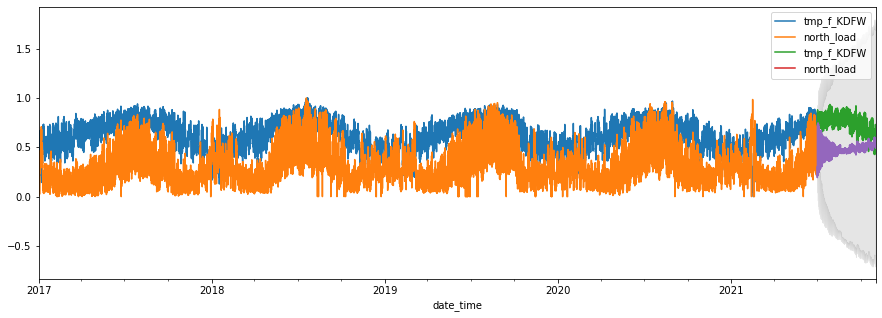

In [61]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2017-01-01':].plot(ax=ax)
target_trans = target_data.copy()
target_trans[['tmp_f_KDFW', 'north_load']] = scaler.transform(target_data[['tmp_f_KDFW', 'north_load']])
target_trans.plot(ax=ax)

# Construct the forecasts
fcast, conf_vals = model.predict(len(target_data), X=target_trans.tmp_f_KDFW.values.reshape(-1,1), return_conf_int = True)
fcast = pd.Series(fcast, index=target_trans.index, name='north_load_pred')

fcast.plot()

lower_bounds = pd.Series(conf_vals[:, 0], index=list(fcast.index))
upper_bounds = pd.Series(conf_vals[:, 1], index=list(fcast.index))
ax.fill_between(fcast.index, lower_bounds, upper_bounds, color='k', alpha=0.1);

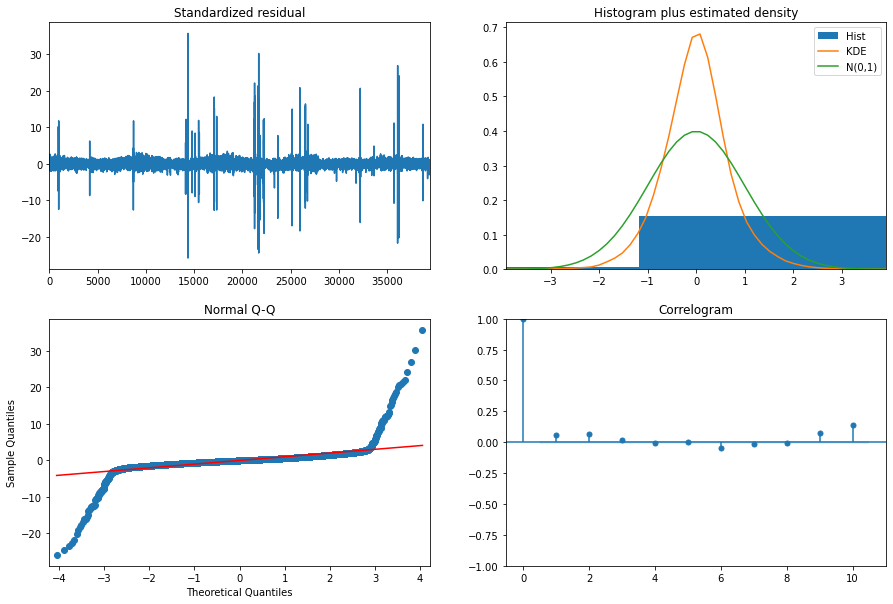

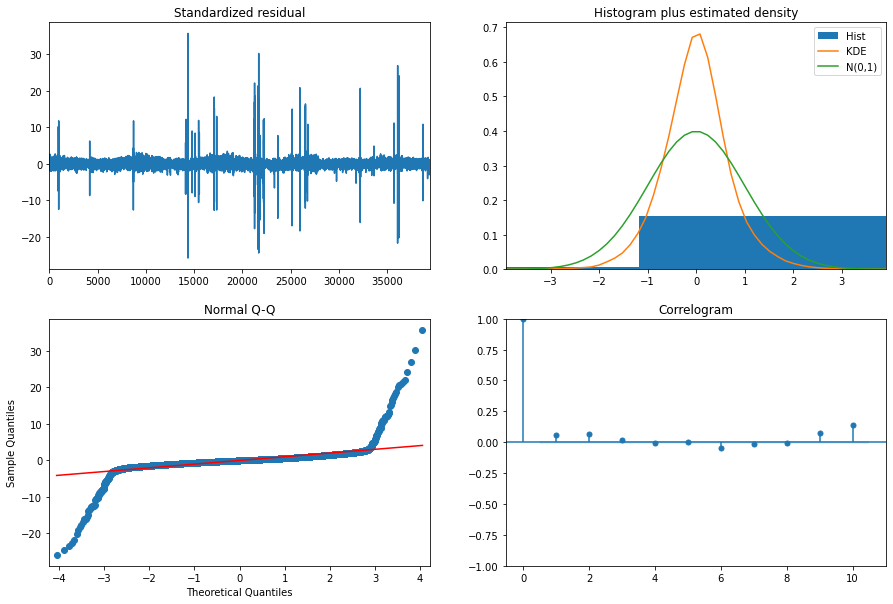

In [70]:
model.model_.plot_diagnostics(figsize=(15,10))

## Seasonal LONNNNNGGG TERM

In [ ]:
model = pm.arima.AutoARIMA(start_p = 24,
                           d = None,
                           start_q = 6,
                           max_p = 48,
                           max_q = 12,
                           m=8760,
                           seasonal=True,
                           trace=2)

model.fit(y=train_data.north_load, X=train_data.tmp_f_KDFW.values.reshape(-1,1))

Performing stepwise search to minimize aic


In [ ]:
model.summary()

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2017-01-01':].plot(ax=ax)
target_trans = target_data.copy()
target_trans[['tmp_f_KDFW', 'north_load']] = scaler.transform(target_data[['tmp_f_KDFW', 'north_load']])
target_trans.plot(ax=ax)

# Construct the forecasts
fcast, conf_vals = model.predict(len(target_data), X=target_trans.tmp_f_KDFW.values.reshape(-1,1), return_conf_int = True)
fcast = pd.Series(fcast, index=target_trans.index, name='north_load_pred')

fcast.plot()

lower_bounds = pd.Series(conf_vals[:, 0], index=list(fcast.index))
upper_bounds = pd.Series(conf_vals[:, 1], index=list(fcast.index))
ax.fill_between(fcast.index, lower_bounds, upper_bounds, color='k', alpha=0.1);

In [ ]:
model.model_.plot_diagnostics(figsize=(15,10))